# Calibration of a statistical test for signature change significance
The objective of this notebook is to calibrate a statistical test to assess the significance of a change in signatures between different clones. To that end, we compare the likelihood of a Clonesig model with $J$ clones as determined by the model selection criterion, and the likelihood of a model with the same clones but a single mixture of signatures common to all the clones (and found by fitting all observed mutations together). The objective of the test is to determine whether the difference between the two likelihoods is significant. To that end, we have implemented a Likelihood-ratio test. We define

$$\lambda=\frac{\ell_{sigCst}}{\ell_{sigChange}}$$

Following the Neyman–Pearson lemma one can set a threshold $c$ to reject the null hypothesis that there is no signature change if $\lambda$ is lower or equal to $c$ with a certain level of significance $\alpha$ determined by the distributions of the likelihood of the model. As this distribution is unknown, we follow the Wilks theorem stating that asymptotically, $-2\log(\lambda)$ follows a chi-squared distribution of parameter the difference in dimensionality between the two alterative models.

A previously illustrated for the model selection criterion, the number of parameters is different from the degree of freedom in the case of Clonesig, so we have resorted to simulations to fit the degree of freedom of the test. We have followed the same simulation scheme as previously, but with a similar mixture of signatures for all clones of each sample, and of course focused on samples with at least 2 clones.

## The distribution of $-2\log(\lambda)$ follows a chi-squared distribution

In [103]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from clonesig.data_loader import MAFLoader, SimLoader, beta_binomial
from clonesig.estimator import _get_projected
from clonesig.estimator import *
import time
from sklearn.cluster import KMeans
from sklearn import linear_model
from scipy.spatial.distance import cosine
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns = 200
phd_folder_path = '/Users/JudithAbecassis/Documents/PhD'
os.chdir('{}/TCGA_signatures'.format(phd_folder_path))
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
table = pd.read_csv('20190613_clonesig_model_selection.csv', sep='\t')
table = table.assign(lambda_MU=2*(table.loglikelihood_MU - table.loglikelihood_nopi_MU))
table = table.assign(lambda_subMU=2*(table.loglikelihood_subMU - table.loglikelihood_nopi_subMU))

We represent here the empirical distributions of $-2\log(\lambda)$ for application of Clonesig with all the 65 signatures (above), or the cancer type-specific subset of signatures (below).

empirical difference of parameters for 2 clones 15.727244776476942
empirical difference of parameters for 3 clones 28.008570243501577
empirical difference of parameters for 4 clones 38.751944022326164
empirical difference of parameters for 5 clones 48.08977796908606
empirical difference of parameters for 6 clones 53.041469069187066


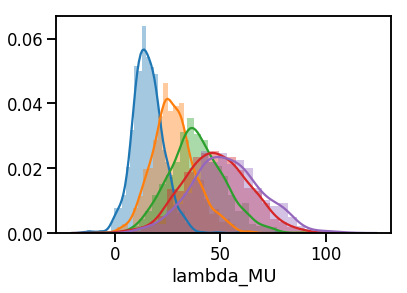

In [143]:
sns.set_context('talk')
for i in range(2, 7):
    sns.distplot(table[table.nb_clones==i]['lambda_MU'])
    print('empirical difference of parameters for', i, 'clones', table[table.nb_clones==i]['lambda_MU'].mean())
#plt.legend(labels=['2 clones','3 clones','4 clones','5 clones','6 clones'], loc=2, bbox_to_anchor=[1,1.05])
plt.savefig('20190801_paper_figures/chi_sq_mu.pdf', bbox_inches='tight')

6.050460106979283
11.320618875809915
16.52191392436831
21.22496933734172
24.985285288985523


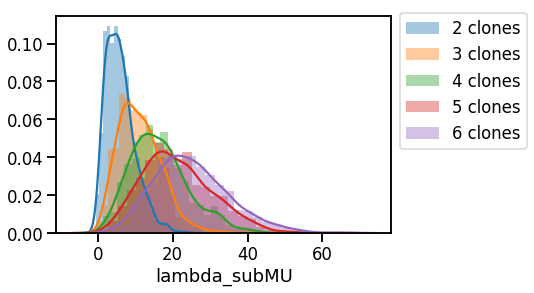

In [12]:
sns.set_context('talk')
for i in range(2, 7):
    sns.distplot(table[table.nb_clones==i]['lambda_subMU'])
    print('empirical difference of parameters for', i, 'clones', table[table.nb_clones==i]['lambda_subMU'].mean())
plt.legend(labels=['2 clones','3 clones','4 clones','5 clones','6 clones'], loc=2, bbox_to_anchor=[1,1.05])
plt.savefig('20190801_paper_figures/chi_sq_submu.pdf', bbox_inches='tight')


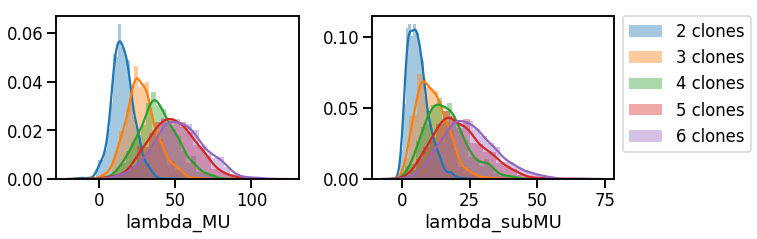

In [147]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
for i in range(2, 7):
    sns.distplot(table[table.nb_clones==i]['lambda_MU'], ax=ax[0])
for i in range(2, 7):
    sns.distplot(table[table.nb_clones==i]['lambda_subMU'], ax=ax[1])
ax[1].legend(labels=['2 clones','3 clones','4 clones','5 clones','6 clones'], loc=2, bbox_to_anchor=[1,1.05])
plt.subplots_adjust(wspace=0.3)
plt.savefig('20190801_paper_figures/chi_sq.pdf', bbox_inches='tight')


In [38]:
sig_file_path = 'external_data/sigProfiler_SBS_signatures_2018_03_28.csv'
cancer_type_sig_filename = 'external_data/match_cancer_type_sig_v3.csv'

# open the matrix describing the signatures
SIG = pd.read_csv(sig_file_path)
SIG_MATRIX = SIG.values[:, 2:].astype(float).T
L, K = SIG_MATRIX.shape
NEW_SIG_MATRIX = SIG_MATRIX + 10**-20 * (SIG_MATRIX == 0)
MU = NEW_SIG_MATRIX / NEW_SIG_MATRIX.sum(axis=1)[:, np.newaxis]

# get the signatures specific of the cancer type
cancer_type_sig = pd.read_csv(cancer_type_sig_filename, index_col=0)
#select = cancer_type_sig[cancer_type, :]
#subMU = MU[select.astype(bool), :]


nb_sig_list = list()
dof_list = list()
median_list = list()
mean_list = list()
for i, cancer_type in enumerate(cancer_type_sig.index.unique()):
    select = cancer_type_sig.loc[cancer_type, :].values
    subMU = MU[select.astype(bool), :]
    ev, _ = np.linalg.eig(1-sp.spatial.distance.squareform(sp.spatial.distance.pdist(subMU, 'cosine')))
    subL = subMU.shape[0]
    nb_sig_list.append(subL)
    dof_list.append(sum(ev>0.5))
df_cancer_type = pd.DataFrame(data=np.array([nb_sig_list, dof_list]).T, columns=['nb_sig', 'dof'], index=cancer_type_sig.index)

df_cancer_type = df_cancer_type.assign(cancer_type = list(range(len(df_cancer_type))))
table_dof = pd.merge(table, df_cancer_type[['cancer_type', 'dof']], on=['cancer_type'])
table_dof_all = pd.melt(table_dof, id_vars=['nb_mut', 'nb_clones', 'cancer_type', 'seed', 'perc_dip', 'dof'], value_vars=['lambda_subMU', 'lambda_MU'])
table_dof_all.loc[table_dof_all.variable=='lambda_MU', 'dof'] = 26


## Research of other relevant covariates besides the number of clones
We have oberved as expected a variation of the empirical difference of parameters with the number of clones. Here we explore the correlation of $-2\log(\lambda)$ with other covariates. We see an important correlation with the degree of freedom of the input signature matrix, and a very weak one with the number of mutations and the diploid proportion of the genome.

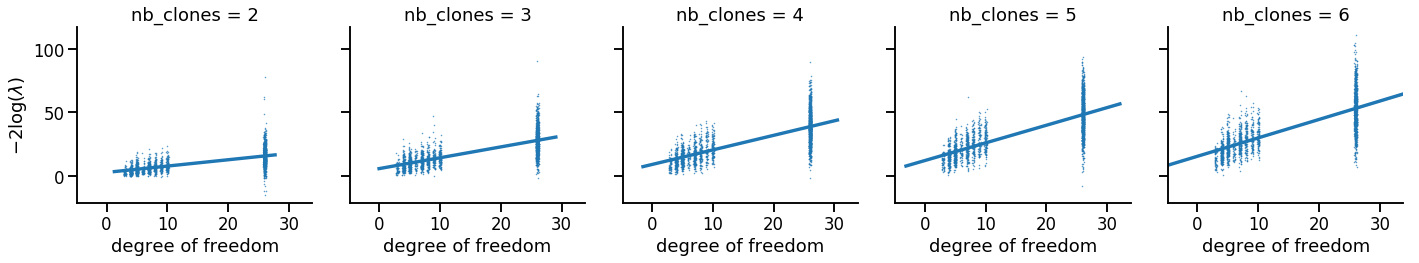

In [35]:
g = sns.lmplot(x="dof", y="value", col="nb_clones", data=table_dof_all, markers='.', x_jitter=0.2, height=4, aspect=1, scatter_kws={"s": 1})
g.axes[0,0].set_ylabel('$-2\log(\lambda)$')
for i in range(5):
    g.axes[0,i].set_xlabel('degree of freedom')
plt.savefig('20190801_paper_figures/chi_sq_param_vs_dof.pdf', bbox_inches='tight')


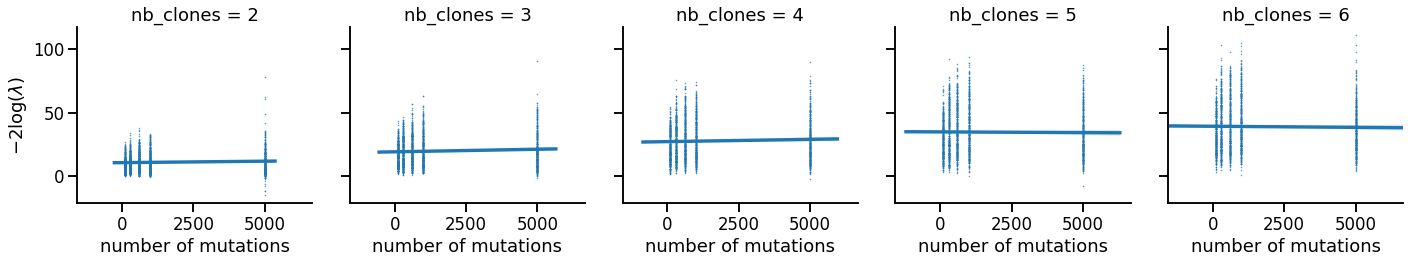

In [39]:
g = sns.lmplot(x="nb_mut", y="value", col="nb_clones", data=table_dof_all, markers='.', x_jitter=0.2, height=4, aspect=1, scatter_kws={"s": 1})
g.axes[0,0].set_ylabel('$-2\log(\lambda)$')
for i in range(5):
    g.axes[0,i].set_xlabel('number of mutations')
plt.savefig('20190801_paper_figures/chi_sq_param_vs_nbmut.pdf', bbox_inches='tight')


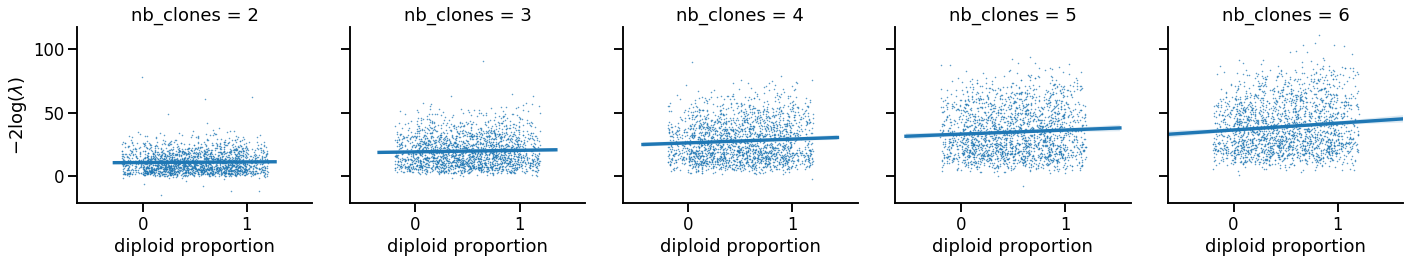

In [40]:
g = sns.lmplot(x="perc_dip", y="value", col="nb_clones", data=table_dof_all, markers='.', x_jitter=0.2, height=4, aspect=1, scatter_kws={"s": 1})
g.axes[0,0].set_ylabel('$-2\log(\lambda)$')
for i in range(5):
    g.axes[0,i].set_xlabel('diploid proportion')
plt.savefig('20190801_paper_figures/chi_sq_param_vs_dipprop.pdf', bbox_inches='tight')


In [105]:
np.random.seed(5)
combis = table_dof_all[['cancer_type', 'nb_mut', 'nb_clones', 'perc_dip']].drop_duplicates()
combis = combis.assign(split=np.random.choice(['test', 'train'], p=[0.2, 0.8], size=len(combis)))
simu_split = pd.merge(table_dof_all, combis, on=['cancer_type', 'nb_mut', 'nb_clones', 'perc_dip'])


## Modelisation
### A single model for all available examples
We have attempted to train a single Ridge linear regression model to predict $-2\log(\lambda)$ depending on the 4 considered covariates (first model), or only the two most influent covariates: the number of clones and the degree of freedom. We observe a minor increase in the MSE when considering only 2 covariates, and the regression coefficients are more than 10 times larger for the number of clones and the degree of freedom, so we keep only those two variables for the rest of the analysis.

In [106]:
# avec un seul modèle
X_train, y_train = simu_split[simu_split.split=='train'][['nb_clones', 'dof', 'nb_mut', 'perc_dip']].values, simu_split[simu_split.split=='train'].value.values
X_test, y_test = simu_split[simu_split.split=='test'][['nb_clones', 'dof', 'nb_mut', 'perc_dip']].values, simu_split[simu_split.split=='test'].value.values


scaler = preprocessing.StandardScaler().fit(X_train)
lm = linear_model.Ridge()
lm.fit(scaler.transform(X_train), y_train)

print('train and test mean squared error:', mean_squared_error(lm.predict(scaler.transform(X_train)), y_train),
      mean_squared_error(lm.predict(scaler.transform(X_test)), y_test))
print('coefficient values for "nb_clones", "dof", "nb_mut" and "perc_dip":', lm.coef_)


train and test mean squared error: 122.2169311151988 116.18265143466814
coefficient values for "nb_clones", "dof", "nb_mut" and "perc_dip": [10.0012639  10.59174451  0.20260926  0.92235223]


In [107]:
# avec un seul modèle
X_train, y_train = simu_split[simu_split.split=='train'][['nb_clones', 'dof']].values, simu_split[simu_split.split=='train'].value.values
X_test, y_test = simu_split[simu_split.split=='test'][['nb_clones', 'dof']].values, simu_split[simu_split.split=='test'].value.values


scaler = preprocessing.StandardScaler().fit(X_train)
lm = linear_model.Ridge()
lm.fit(scaler.transform(X_train), y_train)

print('train and test mean squared error:', mean_squared_error(lm.predict(scaler.transform(X_train)), y_train),
      mean_squared_error(lm.predict(scaler.transform(X_test)), y_test))
print('coefficient values for "nb_clones" and "dof":', lm.coef_)


train and test mean squared error: 123.11289864592601 116.99798956687819
coefficient values for "nb_clones" and "dof": [ 9.99478229 10.59177739]


### Separate models for the two fitting scenarios
As for the determination of a model selection criterion, we have considered the opportunity to train two separate models for the case where Clonesig is fit with all signatures or just cancer type-specific signatures.

In [121]:
np.random.seed(5)
coef_df_list = list()
score_list = list()

combis = table_dof_all[['cancer_type', 'nb_mut', 'nb_clones', 'perc_dip']].drop_duplicates()
combis = combis.assign(split=np.random.choice(range(10), size=len(combis)))
simu_split = pd.merge(table_dof_all, combis, on=['cancer_type', 'nb_mut', 'nb_clones', 'perc_dip'])
for repet in range(10):
    coef_df = pd.DataFrame(index=['full', '65sigs', 'submu'], columns=['intercept', 'coef_nb_clones', 'coef_dof'])
    # avec deux modèles

    features = ['nb_clones', 'dof']

    X_train_full, y_train_full = simu_split[(simu_split.split!=repet)][features].values, simu_split[(simu_split.split!=repet)].value.values
    X_test_full, y_test_full = simu_split[(simu_split.split==repet)][features].values, simu_split[(simu_split.split==repet)].value.values

    scaler = preprocessing.StandardScaler().fit(X_train)
    lm_full = linear_model.Ridge()
    lm_full.fit(X_train_full, y_train_full)
    coef_df.loc['full', 'intercept'] = lm_full.intercept_
    coef_df.loc['full', 'coef_nb_clones'] = lm_full.coef_[0]
    coef_df.loc['full', 'coef_dof'] = lm_full.coef_[1]
    

    X_train_65sigs, y_train_65sigs = simu_split[(simu_split.split!=repet) & (simu_split.variable=='lambda_MU')][features].values, simu_split[(simu_split.split!=repet) & (simu_split.variable=='lambda_MU')].value.values
    X_test_65sigs, y_test_65sigs = simu_split[(simu_split.split==repet) & (simu_split.variable=='lambda_MU')][features].values, simu_split[(simu_split.split==repet) & (simu_split.variable=='lambda_MU')].value.values

    scaler = preprocessing.StandardScaler().fit(X_train)
    lm_65sigs = linear_model.Ridge()
    lm_65sigs.fit(X_train_65sigs, y_train_65sigs)
    coef_df.loc['65sigs', 'intercept'] = lm_65sigs.intercept_
    coef_df.loc['65sigs', 'coef_nb_clones'] = lm_65sigs.coef_[0]
    coef_df.loc['65sigs', 'coef_dof'] = lm_65sigs.coef_[1]

    # avec deux modèles
    X_train_submu, y_train_submu = simu_split[(simu_split.split!=repet) & (simu_split.variable=='lambda_subMU')][features].values, simu_split[(simu_split.split!=repet) & (simu_split.variable=='lambda_subMU')].value.values
    X_test_submu, y_test_submu = simu_split[(simu_split.split==repet) & (simu_split.variable=='lambda_subMU')][features].values, simu_split[(simu_split.split==repet) & (simu_split.variable=='lambda_subMU')].value.values

    scaler = preprocessing.StandardScaler().fit(X_train)
    lm_submu = linear_model.Ridge()
    lm_submu.fit(X_train_submu, y_train_submu)
    coef_df.loc['submu', 'intercept'] = lm_submu.intercept_
    coef_df.loc['submu', 'coef_nb_clones'] = lm_submu.coef_[0]
    coef_df.loc['submu', 'coef_dof'] = lm_submu.coef_[1]
    
    
    score_list.append([mean_squared_error(lm_full.predict(X_train_full), y_train_full),
      mean_squared_error(lm_full.predict(X_test_full), y_test_full), mean_squared_error(np.concatenate((lm_65sigs.predict(X_train_65sigs), lm_submu.predict(X_train_submu))), np.concatenate((y_train_65sigs, y_train_submu))),
          mean_squared_error(np.concatenate((lm_65sigs.predict(X_test_65sigs), lm_submu.predict(X_test_submu))), np.concatenate((y_test_65sigs, y_test_submu)))])
    coef_df_list.append(coef_df)


We evaluate the value and stability of coefficients using 10-fold cross-validation (the two fits corresponding to a same sample are in the same fold) by computing the mean and 95% confidence interval for the coefficients.

In [109]:
p = pd.Panel({n: df for n, df in enumerate(coef_df_list)})

In [110]:
p.mean(axis=0)

,intercept,coef_nb_clones,coef_dof
full,-19.419986,7.123783,1.068662
65sigs,-1.155825,9.469915,0.000000
submu,-13.676675,4.776926,1.662039


In [111]:
1.96 * p.std(axis=0) / np.sqrt(10)

,intercept,coef_nb_clones,coef_dof
full,0.058904,0.016869,0.002100
65sigs,0.106790,0.027869,0.000000
submu,0.077720,0.011700,0.009906


Evaluation of the train and test score in cross validation for the complete model and the separate model. We obtain better scores with the separate model, which we select.

In [112]:
np.array(score_list).mean(axis=0)

array([121.92495753, 121.87331924, 110.09506804, 110.07542486])

In [113]:
np.array(score_list).std(axis=0)

array([0.89109411, 8.17103208, 0.95940542, 8.75867915])

and apply the test using those values. For intermediate values between the maximal cancer type degree of freedom and 26, we have used the coefficients of the global model, otherwise, the separate model.

In [130]:
def get_ll_test_dof(dof, nb_clones):
    """
    better model in the future, for now just coming from the simulations with
    30 signatures, without copy number. Will provide a better model later...
    """
    if dof == 26:
        return -1.156 + 9.470 * nb_clones + 0 * dof
    elif dof <= 12:
        return -13.677 + 4.777 * nb_clones + 1.662 * dof
    else:
        return -19.420 + 7.124 * nb_clones + 1.069 * dof

def lrtest(ll_ratio, dof):
    lr = 2 * (ll_ratio)
    sp.stats.chisqprob = lambda chisq, df: sp.stats.chi2.sf(chisq, df)
    #p = sp.stats.chisqprob(lr, dof) # llmax has 1 dof more than llmin
    p=sp.stats.distributions.chi2.sf(lr, dof)
    return lr, p

In [137]:
table_dof_all = table_dof_all.assign(dofb=pd.Categorical(table_dof_all.dof, categories=list(range(3, 27)), ordered=True))
table_dof_all=table_dof_all.assign(test_dof=table_dof_all.apply(lambda x: get_ll_test_dof(x['dofb'], x['nb_clones']), axis=1))
table_dof_all=table_dof_all.assign(pvalue=table_dof_all.apply(lambda x: lrtest(x['value']/2, x['test_dof'])[1], axis=1))
table_dof_all=table_dof_all.assign(sig=table_dof_all.pval_test<0.05)


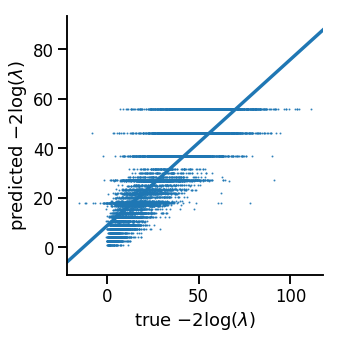

In [141]:
ax = sns.lmplot(x='value', y='test_dof', data=table_dof_all, scatter_kws={"s": 1})
ax.set_xlabels("true $-2\log(\lambda)$")
ax.set_ylabels("predicted $-2\log(\lambda)$")
plt.savefig('20190801_paper_figures/prediction_accuracy_statistical_test_dof.pdf', bbox_inches='tight')

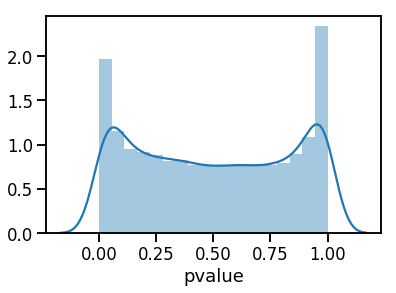

In [142]:
sns.distplot(table_dof_all.pvalue)
plt.savefig('20190801_paper_figures/pval_empirical_distribution.pdf', bbox_inches='tight')